# Process the Health Data and Blood Sugar Data

## Extract Apple Health Data and Export to CSVs
* Command Line Tool to Process apple health's export.xml file 
* Create multiple CSV files for each data type. 
* Original Source: https://github.com/tdda/applehealthdata
### Setup and Usage
* Export your data from Apple Health App on your phone. 
* Unzip export.zip into the DATA directory.
* Inside your directory there should be a directory and file here: /DATA/export/apple_health_export/export.xml
* Run the following command

In [ ]:
%run -i apple-health-data-parser.py DATA/export/apple_health_export/export.xml

## Process Active Calorie Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [53]:
calories = pd.read_csv(r'DATA\export\apple_health_export\ActiveEnergyBurned.csv')
calories = calories[calories['sourceName'] == "Tyler’s Apple\xa0Watch"]
print(f"Units are {calories['unit'][0]}")

Units are Cal


Trim the data to include only the relevant date range

In [58]:
cals = calories[calories['startDate'].str.startswith("2024-05")][['startDate', 'endDate', 'value']]
cals['start'] = pd.to_datetime(cals['startDate'])
cals['end'] = pd.to_datetime(cals['endDate'])
cals = cals[(cals['start'] > '2024-05-12') & (cals['start'] < '2024-05-24')][['start', 'end', 'value']].reset_index(drop=True)
cals

,start,end,value
0,2024-05-12 09:30:42-07:00,2024-05-12 09:40:46-07:00,5.166
1,2024-05-12 09:40:46-07:00,2024-05-12 09:41:27-07:00,0.280
2,2024-05-12 09:41:27-07:00,2024-05-12 09:51:28-07:00,2.852
3,2024-05-12 09:51:28-07:00,2024-05-12 09:52:50-07:00,1.184
4,2024-05-12 09:52:50-07:00,2024-05-12 10:02:41-07:00,5.669
...,...,...,...
20394,2024-05-23 19:48:29-07:00,2024-05-23 19:58:00-07:00,2.940
20395,2024-05-23 19:58:30-07:00,2024-05-23 20:08:32-07:00,8.752
20396,2024-05-23 20:08:32-07:00,2024-05-23 20:17:32-07:00,19.751
20397,2024-05-23 20:19:34-07:00,2024-05-23 20:29:36-07:00,3.069


In [59]:
cals['power'] = cals['value'] / (cals['end'] - cals['start']).dt.total_seconds()
cals['day'] = cals['start'].dt.day
cals['power'].describe()

count    20399.000000
mean         0.126012
std          0.093633
min          0.000168
25%          0.019500
50%          0.140667
75%          0.197667
max          0.393500
Name: power, dtype: float64

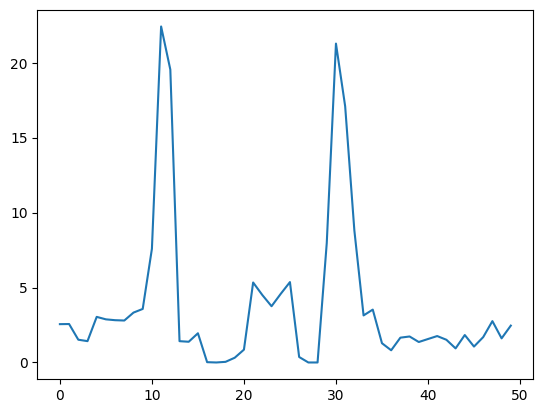

In [91]:
WINDOW_SIZE = 300
cals['elapsed_start'] = (cals['start'] - cals['start'].min()).dt.total_seconds()
cals['elapsed_end'] = (cals['end'] - cals['start'].min()).dt.total_seconds()
rolling_avg = []
for i in range(0, int(cals['elapsed_end'].max()), WINDOW_SIZE):
    within_window = cals[(cals['elapsed_start'] >= i) & (cals['elapsed_end'] < i + WINDOW_SIZE)]['value'].sum()
    
    start_mask = (cals['elapsed_start'] < i) & (cals['elapsed_end'] >= i)
    within_start = (cals[start_mask]['power'] * np.minimum((cals[start_mask]['elapsed_end'] - i), WINDOW_SIZE)).sum()

    end_mask = (cals['elapsed_start'] < i + WINDOW_SIZE) & (cals['elapsed_end'] >= i + WINDOW_SIZE)
    within_end = (cals[end_mask]['power'] * np.minimum(i + WINDOW_SIZE - 1 - cals[end_mask]['elapsed_start'], WINDOW_SIZE)).sum()

    entire_mask = (cals['elapsed_start'] < i) & (cals['elapsed_end'] >= i + WINDOW_SIZE)
    within_entire = (cals[entire_mask]['power'] * WINDOW_SIZE).sum()
    
    rolling_avg.append((within_window + within_start + within_end - within_entire))

plt.plot(rolling_avg[:50])
plt.show()

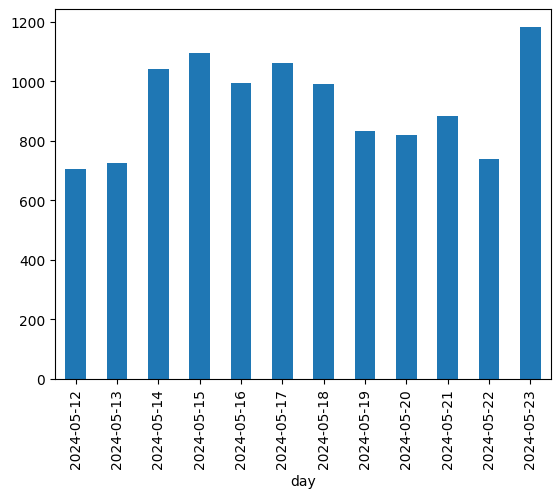

In [93]:
cal_df = pd.DataFrame(rolling_avg, columns=['calories'])
cal_df['datetime'] = pd.date_range(start=cals['start'].min(), periods=len(rolling_avg), freq=f'{WINDOW_SIZE}s')
# plot by day
cal_df['day'] = cal_df['datetime'].dt.date
cal_df['day'].unique()
cal_df.groupby('day')['calories'].sum().plot(kind='bar')
plt.show()

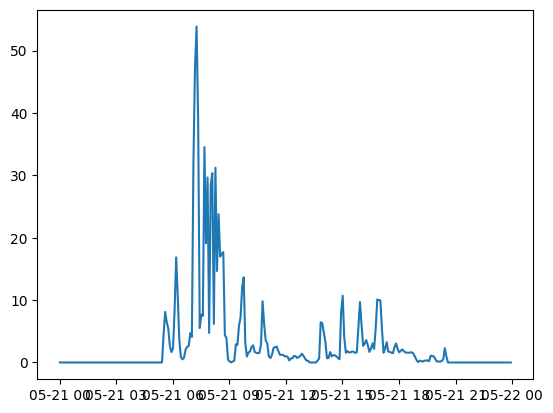

In [103]:
# plot the calorie burn for a specific day
days_list = cal_df['day'].unique()
mask = cal_df['day'] == days_list[9]
plt.plot(cal_df[mask]['datetime'], cal_df[mask]['calories'])
plt.show()

## Test Visualization Using Steps

In [3]:
from datetime import datetime
import pytz

In [4]:
steps = pd.read_csv(r'DATA\export\apple_health_export/StepCount.csv')
steps.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
250709,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 09:49:33 -0700,2024-06-12 09:38:50 -0700,2024-06-12 09:38:55 -0700,19
250710,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:15:04 -0700,2024-06-12 10:03:38 -0700,2024-06-12 10:03:48 -0700,20
250711,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:24:50 -0700,2024-06-12 10:13:47 -0700,2024-06-12 10:14:50 -0700,18
250712,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 11:35:26 -0700,2024-06-12 11:24:39 -0700,2024-06-12 11:25:53 -0700,37
250713,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 12:13:37 -0700,2024-06-12 12:02:35 -0700,2024-06-12 12:10:41 -0700,139


In [27]:
# convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/Vancouver'))
convert_tz = lambda x: x
get_year = lambda x: (dt := convert_tz(x)).year
get_month = lambda x: (dt := convert_tz(x)) and f'{dt.year}-{dt.month:02}'
get_date = lambda x: (dt := convert_tz(x)) and f'{dt.year}-{dt.month:02}-{dt.day:02}'
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

steps['startDate'] = pd.to_datetime(steps['startDate'])
steps['year'] = steps['startDate'].map(get_year)
steps['month'] = steps['startDate'].map(get_month)
steps['date'] = steps['startDate'].map(get_date)
steps['day'] = steps['startDate'].map(get_day)
steps['hour'] = steps['startDate'].map(get_hour)
steps['dow'] = steps['startDate'].map(get_day_of_week)

In [28]:
steps = steps[steps.sourceName == 'Tyler’s Apple\xa0Watch']
steps.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,year,month,date,day,hour,dow
250709,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 09:49:33 -0700,2024-06-12 09:38:50-07:00,2024-06-12 09:38:55 -0700,19,2024,2024-06,2024-06-12,12,9,2
250710,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:15:04 -0700,2024-06-12 10:03:38-07:00,2024-06-12 10:03:48 -0700,20,2024,2024-06,2024-06-12,12,10,2
250711,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:24:50 -0700,2024-06-12 10:13:47-07:00,2024-06-12 10:14:50 -0700,18,2024,2024-06,2024-06-12,12,10,2
250712,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 11:35:26 -0700,2024-06-12 11:24:39-07:00,2024-06-12 11:25:53 -0700,37,2024,2024-06,2024-06-12,12,11,2
250713,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 12:13:37 -0700,2024-06-12 12:02:35-07:00,2024-06-12 12:10:41 -0700,139,2024,2024-06,2024-06-12,12,12,2


In [29]:
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')
steps_by_date.tail()

,date,Steps
1443,2024-06-08,18868
1444,2024-06-09,22955
1445,2024-06-10,7505
1446,2024-06-11,13286
1447,2024-06-12,299


In [30]:
steps_by_date.describe()

,Steps
count,1448.000000
mean,12238.957873
std,6358.723010
min,32.000000
25%,8042.500000
50%,11483.000000
75%,15761.750000
max,47209.000000


<AxesSubplot: xlabel='hour'>

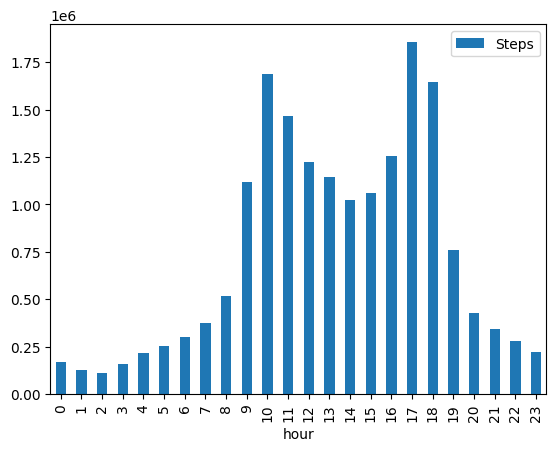

In [31]:
# plot steps by hour of the day
steps_by_hour = steps.groupby(['hour'])['value'].sum().reset_index(name='Steps')
steps_by_hour.plot(x='hour', y='Steps', kind='bar')

<AxesSubplot: xlabel='dow'>

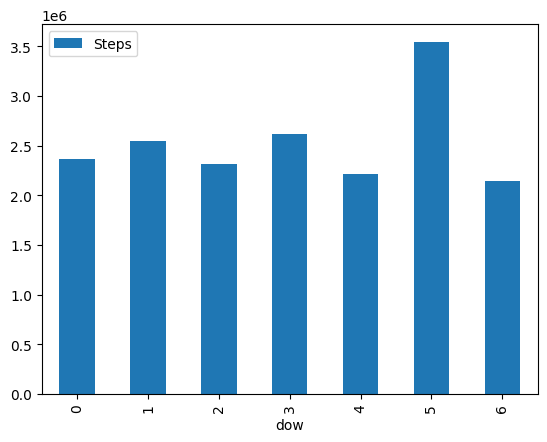

In [34]:
# plot steps by days of the week
steps_by_hour = steps.groupby(['dow'])['value'].sum().reset_index(name='Steps')
steps_by_hour.plot(x='dow', y='Steps', kind='bar')